### Assessment Submission

# Import Libraries & Load Data

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
transaction_data = pd.read_csv("student_dataset.csv")
transaction_data.head()

,Transaction.Date,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,source,browser,Payment.Method,Product.Category,Quantity,Device.Used,Is.Fraudulent
0,2015-05-28 11:15:16,45.00,37,35,11,Ads,Chrome,PayPal,electronics,5,tablet,0
1,2015-04-03 03:39:44,15.00,33,44,3,Direct,FireFox,debit card,health & beauty,5,tablet,1
2,2015-08-31 23:01:21,54.00,19,44,23,SEO,Opera,debit card,health & beauty,1,mobile,0
3,2024-03-10 17:02:40,234.42,23,107,17,Ads,Chrome,bank transfer,electronics,5,tablet,0
4,2024-03-30 08:15:29,412.49,23,220,8,Ads,Safari,bank transfer,toys & games,4,mobile,0


# Data Preprocessing

### Handling Missing Data Value

In [ ]:
#Checking missing values in columns

def check_missing_data(df):
    df.replace(["", "na", "NaN"], np.nan, inplace=True)
    missing_data_summary = df.isnull().sum()
    total_missing = missing_data_summary.sum()
    total_data_points = df.shape[0] * df.shape[1]
    missing_percentage = (total_missing / total_data_points) * 100
    print(f"Total Rows: {df.shape[0]}, Total Columns: {df.shape[1]}")
    print(f"Total Missing Values: {total_missing}")
    print(f"Missing Percentage: {missing_percentage:.2f}%")
    print(missing_data_summary)
    print("\n")

check_missing_data(transaction_data)


Total Rows: 240000, Total Columns: 12
Total Missing Values: 0
Missing Percentage: 0.00%
Transaction.Date      0
Transaction.Amount    0
Customer.Age          0
Account.Age.Days      0
Transaction.Hour      0
source                0
browser               0
Payment.Method        0
Product.Category      0
Quantity              0
Device.Used           0
Is.Fraudulent         0
dtype: int64




In [ ]:
#imputing missing value with median if its int or float and with mode if its string

def impute_missing_values(df):
  for col in df.columns:
    if df[col].isnull().sum() > 0:
      if df[col].dtype.name in ['float64', 'int64', 'int32']:
          df[col].fillna(df[col].median(), inplace=True)
      else:
          df[col].fillna(df[col].mode()[0], inplace=True)
  return df

transaction_data = impute_missing_values(transaction_data)

In [ ]:
transaction_data.head()

,Transaction.Date,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,source,browser,Payment.Method,Product.Category,Quantity,Device.Used,Is.Fraudulent
0,2015-05-28 11:15:16,45.00,37,35,11,Ads,Chrome,PayPal,electronics,5,tablet,0
1,2015-04-03 03:39:44,15.00,33,44,3,Direct,FireFox,debit card,health & beauty,5,tablet,1
2,2015-08-31 23:01:21,54.00,19,44,23,SEO,Opera,debit card,health & beauty,1,mobile,0
3,2024-03-10 17:02:40,234.42,23,107,17,Ads,Chrome,bank transfer,electronics,5,tablet,0
4,2024-03-30 08:15:29,412.49,23,220,8,Ads,Safari,bank transfer,toys & games,4,mobile,0


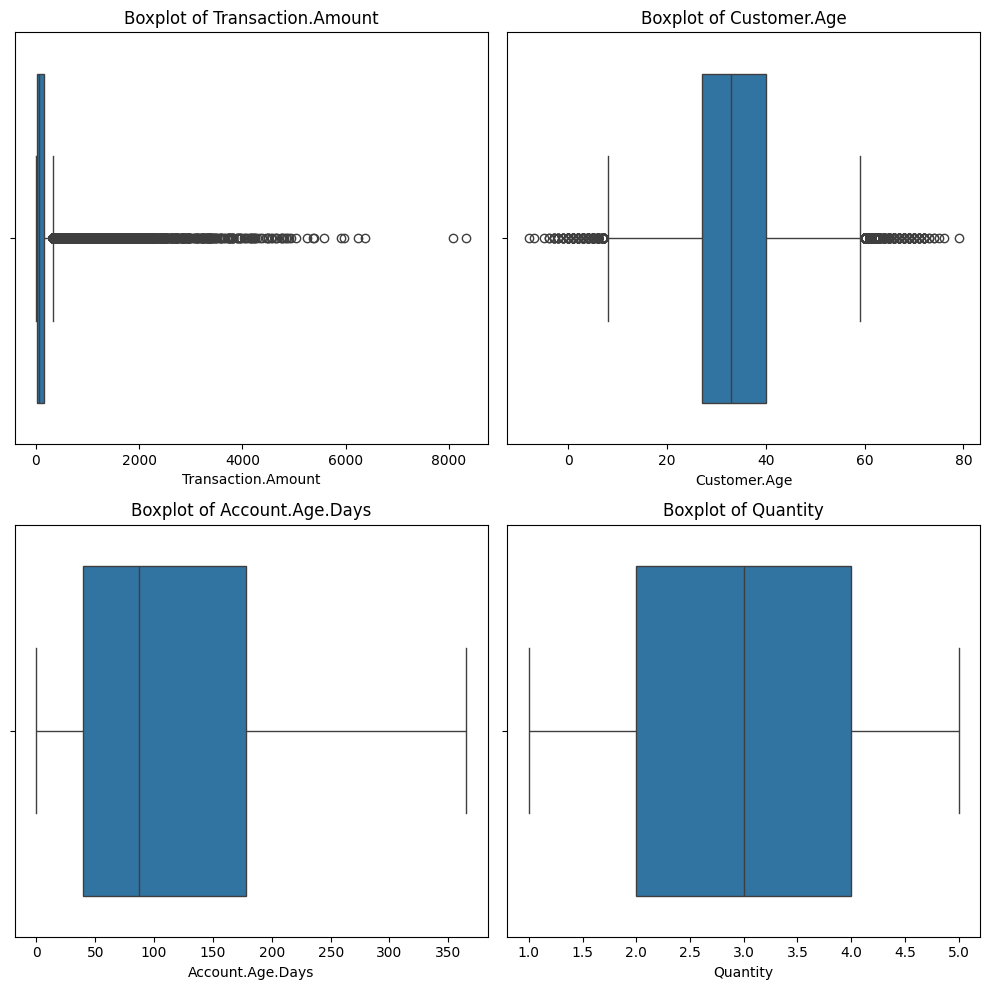

In [ ]:
#Creating box plots to see outliers in numerical columns

def box_plot(df, numeric_cols, cols_per_row=2):
    num_cols = len(numeric_cols)
    rows = math.ceil(num_cols / cols_per_row)  # Calculate required rows

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 5))
    axes = axes.flatten()  # Flatten in case of multiple rows

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')

    # Hide unused/blank subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

numeric_cols = ['Transaction.Amount', 'Customer.Age','Account.Age.Days','Quantity']

box_plot(transaction_data, numeric_cols, cols_per_row=2)

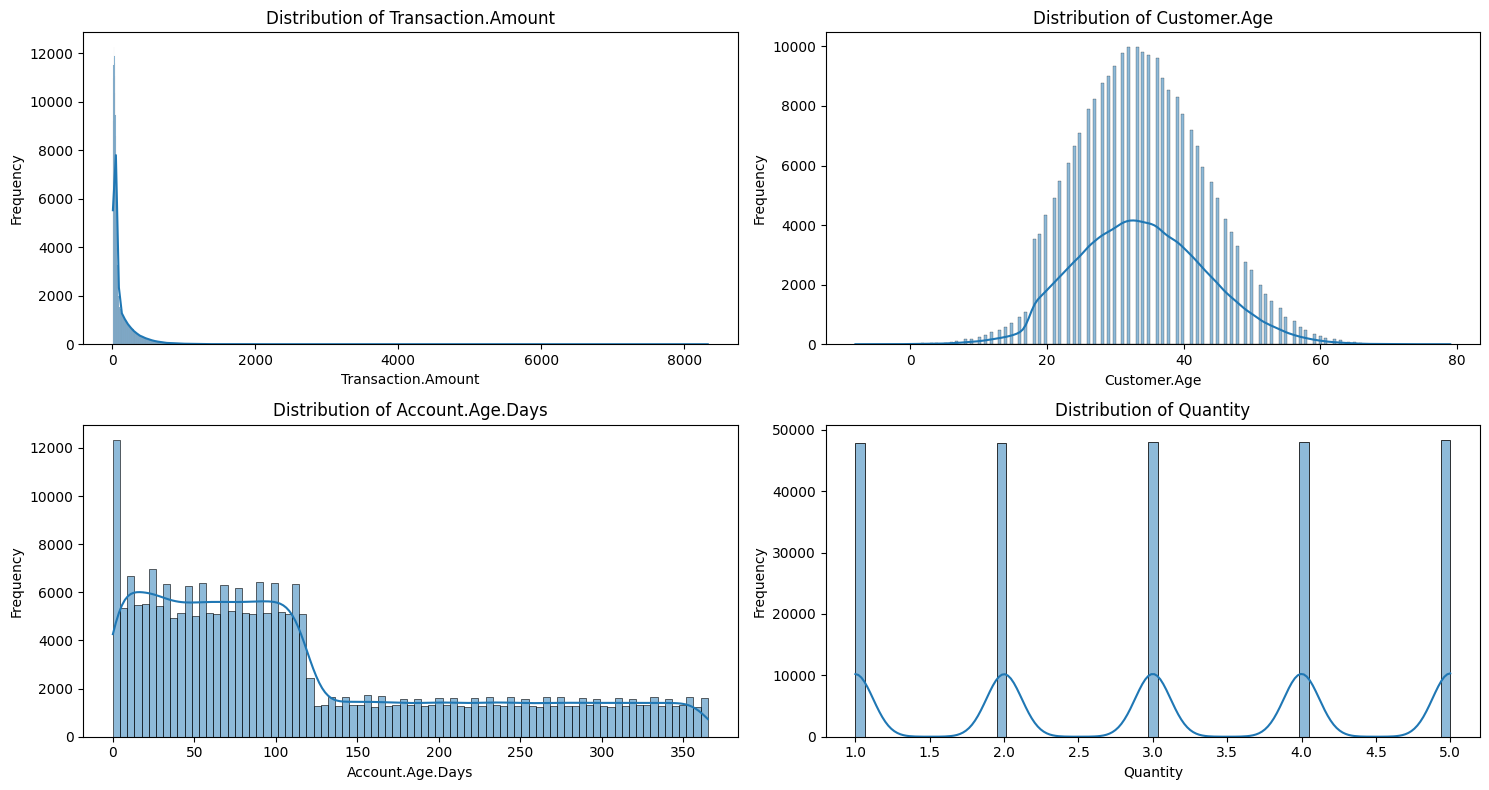

In [ ]:
#Creating histogram to get more clarity on distribution of numerical columns

def visualize_numerical_data(df, columns):


  num_cols = len(columns)
  num_rows = 2
  num_cols_per_row = (num_cols + 1) // num_rows  # Calculate columns per row

  fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(15, 8))
  axes = axes.flatten()  # Flatten the axes array for easier iteration

  for i, col in enumerate(columns):
      sns.histplot(df[col], ax=axes[i], kde=True)
      axes[i].set_title(f'Distribution of {col}')
      axes[i].set_xlabel(col)
      axes[i].set_ylabel('Frequency')

  # Hide unused/blank subplots
  for j in range(i+1, len(axes)):
      axes[j].set_visible(False)

  plt.tight_layout()
  plt.show()


numerical_cols = ['Transaction.Amount', 'Customer.Age', 'Account.Age.Days', 'Quantity']
visualize_numerical_data(transaction_data, numerical_cols)

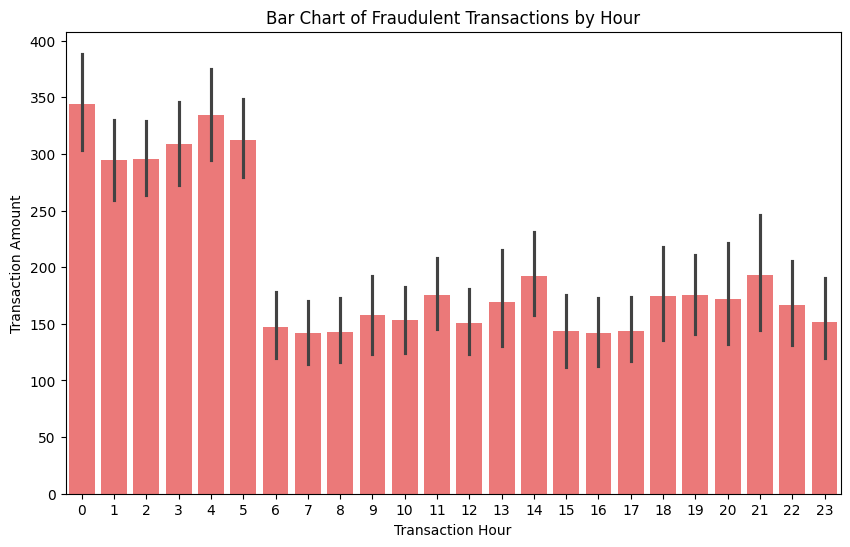

In [ ]:
#Visualising amount of transaction over the hours

def visualize_time_date(df):
  fraud_df = df[df["Is.Fraudulent"] == 1]
  non_fraud_df = df[df["Is.Fraudulent"] == 0]
  plt.figure(figsize=(10, 6))
  sns.barplot(data=fraud_df, x="Transaction.Hour", y="Transaction.Amount", color="red", alpha=0.6)

  plt.xlabel("Transaction Hour")
  plt.ylabel("Transaction Amount")
  plt.title("Bar Chart of Fraudulent Transactions by Hour")
  plt.xticks(range(0, 24))
  plt.show()



visualize_time_date(transaction_data)

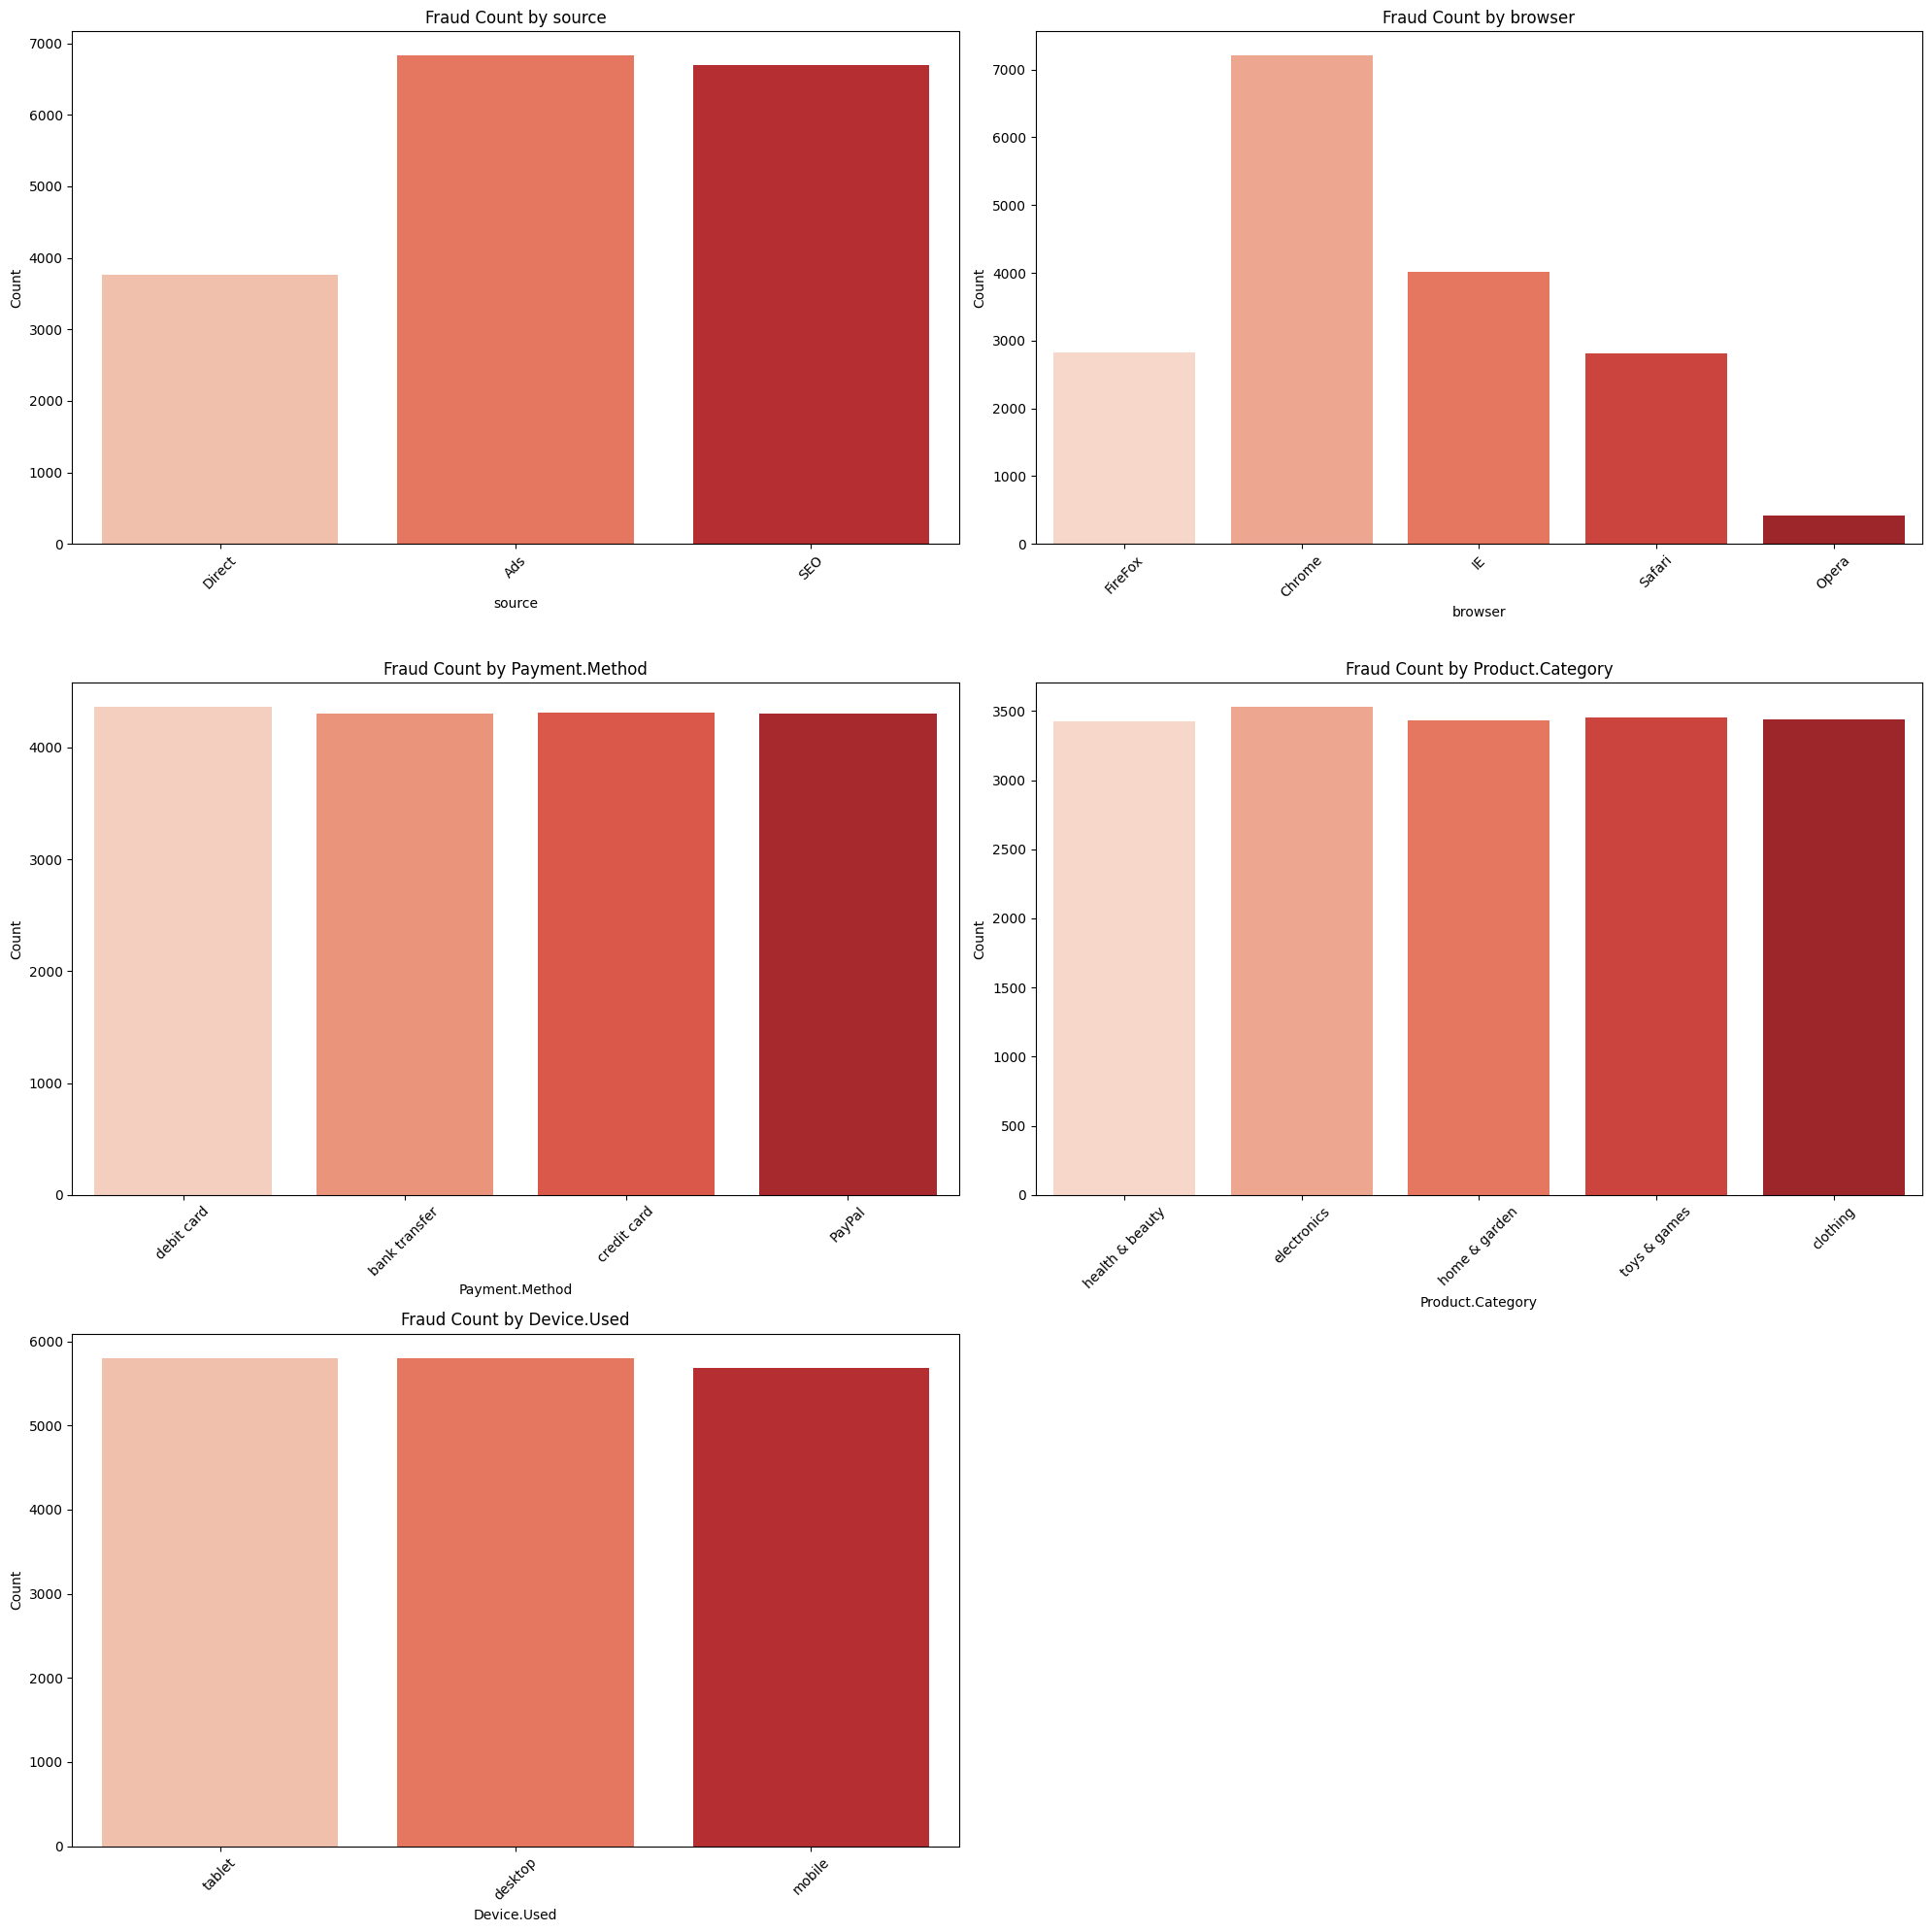

In [ ]:
#Visualising categorical features distribution

def visualize_categorical_data(df, cat_cols):
    fraud_df = df[df["Is.Fraudulent"] == 1]

    # Defining number of rows & columns for better layout
    num_plots = len(cat_cols)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)  # Auto-adjust rows

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 20))

    # Flatten axes array
    axes = axes.flatten()

    # Iterate through categorical columns and create count plots
    for i, col in enumerate(cat_cols):
        sns.countplot(data=fraud_df, x=col, ax=axes[i], palette="Reds")
        axes[i].set_title(f"Fraud Count by {col}", fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel("Count", fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)

    # Hide unused/blank subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

cat_cols = ['source', 'browser', 'Payment.Method', 'Product.Category', 'Device.Used']
visualize_categorical_data(transaction_data, cat_cols)


### Based on the observation of above plots, we are creating additional features like:

    
    

*   **Time-based features**: transaction_year, transaction_day, transaction_month, transaction_week, transaction_time, day_of_week, time_of_day, is_weekend, late_night
*   **Outlier Smoothening features**: amount_bin, Customer.AgeGroup, Account.AgeGroup
*   **Interaction Features**: source_browser_combo, device_time_of_day_combo, payment_product_category_combo
*   **Risk-Based Features**: is_new_customer_using_credit_card, is_old_customer_using_new_device, high_risk_payment_method, new_account_high_amount



In [ ]:
def preprocess_data(df):

    #Time-based features

    df['Transaction.Date'] = pd.to_datetime(df['Transaction.Date'], errors='coerce')

    df['transaction_date'] = df['Transaction.Date'].dt.date
    df['transaction_time'] = df['Transaction.Date'].dt.time
    df['transaction_hour'] = df['Transaction.Date'].dt.hour
    df['transaction_day'] = df['Transaction.Date'].dt.day
    df['transaction_year'] = df['Transaction.Date'].dt.year

    if df['Transaction.Date'].notna().all():
       df['transaction_week'] = df['Transaction.Date'].dt.isocalendar().week.astype('Int64')
    else:
       df['transaction_week'] = df['Transaction.Date'].dt.isocalendar().week
    df['transaction_month'] = df['Transaction.Date'].dt.month
    df['day_of_week'] = df['Transaction.Date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x > 5 else 0)
    df[['transaction_year', 'transaction_month', 'transaction_day', 'transaction_hour']] = df[[
        'transaction_year', 'transaction_month', 'transaction_day', 'transaction_hour'
    ]].fillna(-1).astype(int)

    def time_of_day(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 21:
            return 'evening'
        else:
            return 'night'

    df['time_of_day'] = df['transaction_hour'].apply(time_of_day)
    df['late_night'] = df['Transaction.Hour'].apply(lambda x: 1 if x < 6 else 0)

    df['amount_bin'] = pd.qcut(df['Transaction.Amount'], q=4, labels=['low', 'medium', 'high', 'very_high'])
    df = df[df['Customer.Age'] >= 0]

    # Binning Customer Age into categories
    df['Customer.AgeGroup'] = pd.cut(df['Customer.Age'], bins=[-1, 25, 45, 65, 101],
                                    labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])

    # Binning Account Age
    df['Account.AgeGroup'] = pd.cut(df['Account.Age.Days'], bins=[-1, 8, 30, 180, 366],
                                    labels=['Very_New', 'New', 'Medium', 'Old'])



    df.dropna(subset=['Transaction.Date'], inplace=True)

    # Interaction Features
    df['source_browser_combo'] = df['source'] + "_" + df['browser']
    df['device_time_of_day_combo'] = df['Device.Used'] + "_" + df['time_of_day']
    df['payment_product_category_combo'] = df['Payment.Method'] + "_" + df['Product.Category']

    # Risk-Based Features
    df['is_new_customer_using_credit_card'] = ((df['Account.AgeGroup'] == 'New') &
                                               (df['Payment.Method'] == 'credit card')).astype(int)
    df['is_old_customer_using_new_device'] = ((df['Account.AgeGroup'] == 'Old') &
                                              (df['Device.Used'] != df.groupby('Customer.Age')['Device.Used'].shift(1))).astype(int)

    df['new_account_high_amount'] = ((df['Account.Age.Days'] <= 7) & (df['Transaction.Amount'] > 6000)).astype(int)

    # Dropping duplicate column
    df = df.drop(columns = ['transaction_hour'])

    return df

transaction_data = preprocess_data(transaction_data)
transaction_data.head()


,Transaction.Date,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,source,browser,Payment.Method,Product.Category,Quantity,...,late_night,amount_bin,Customer.AgeGroup,Account.AgeGroup,source_browser_combo,device_time_of_day_combo,payment_product_category_combo,is_new_customer_using_credit_card,is_old_customer_using_new_device,new_account_high_amount
0,2015-05-28 11:15:16,45.00,37,35,11,Ads,Chrome,PayPal,electronics,5,...,0,medium,Middle-aged,Medium,Ads_Chrome,tablet_morning,PayPal_electronics,0,0,0
1,2015-04-03 03:39:44,15.00,33,44,3,Direct,FireFox,debit card,health & beauty,5,...,1,low,Middle-aged,Medium,Direct_FireFox,tablet_night,debit card_health & beauty,0,0,0
2,2015-08-31 23:01:21,54.00,19,44,23,SEO,Opera,debit card,health & beauty,1,...,0,high,Young,Medium,SEO_Opera,mobile_night,debit card_health & beauty,0,0,0
3,2024-03-10 17:02:40,234.42,23,107,17,Ads,Chrome,bank transfer,electronics,5,...,0,very_high,Young,Medium,Ads_Chrome,tablet_evening,bank transfer_electronics,0,0,0
4,2024-03-30 08:15:29,412.49,23,220,8,Ads,Safari,bank transfer,toys & games,4,...,0,very_high,Young,Old,Ads_Safari,mobile_morning,bank transfer_toys & games,0,1,0


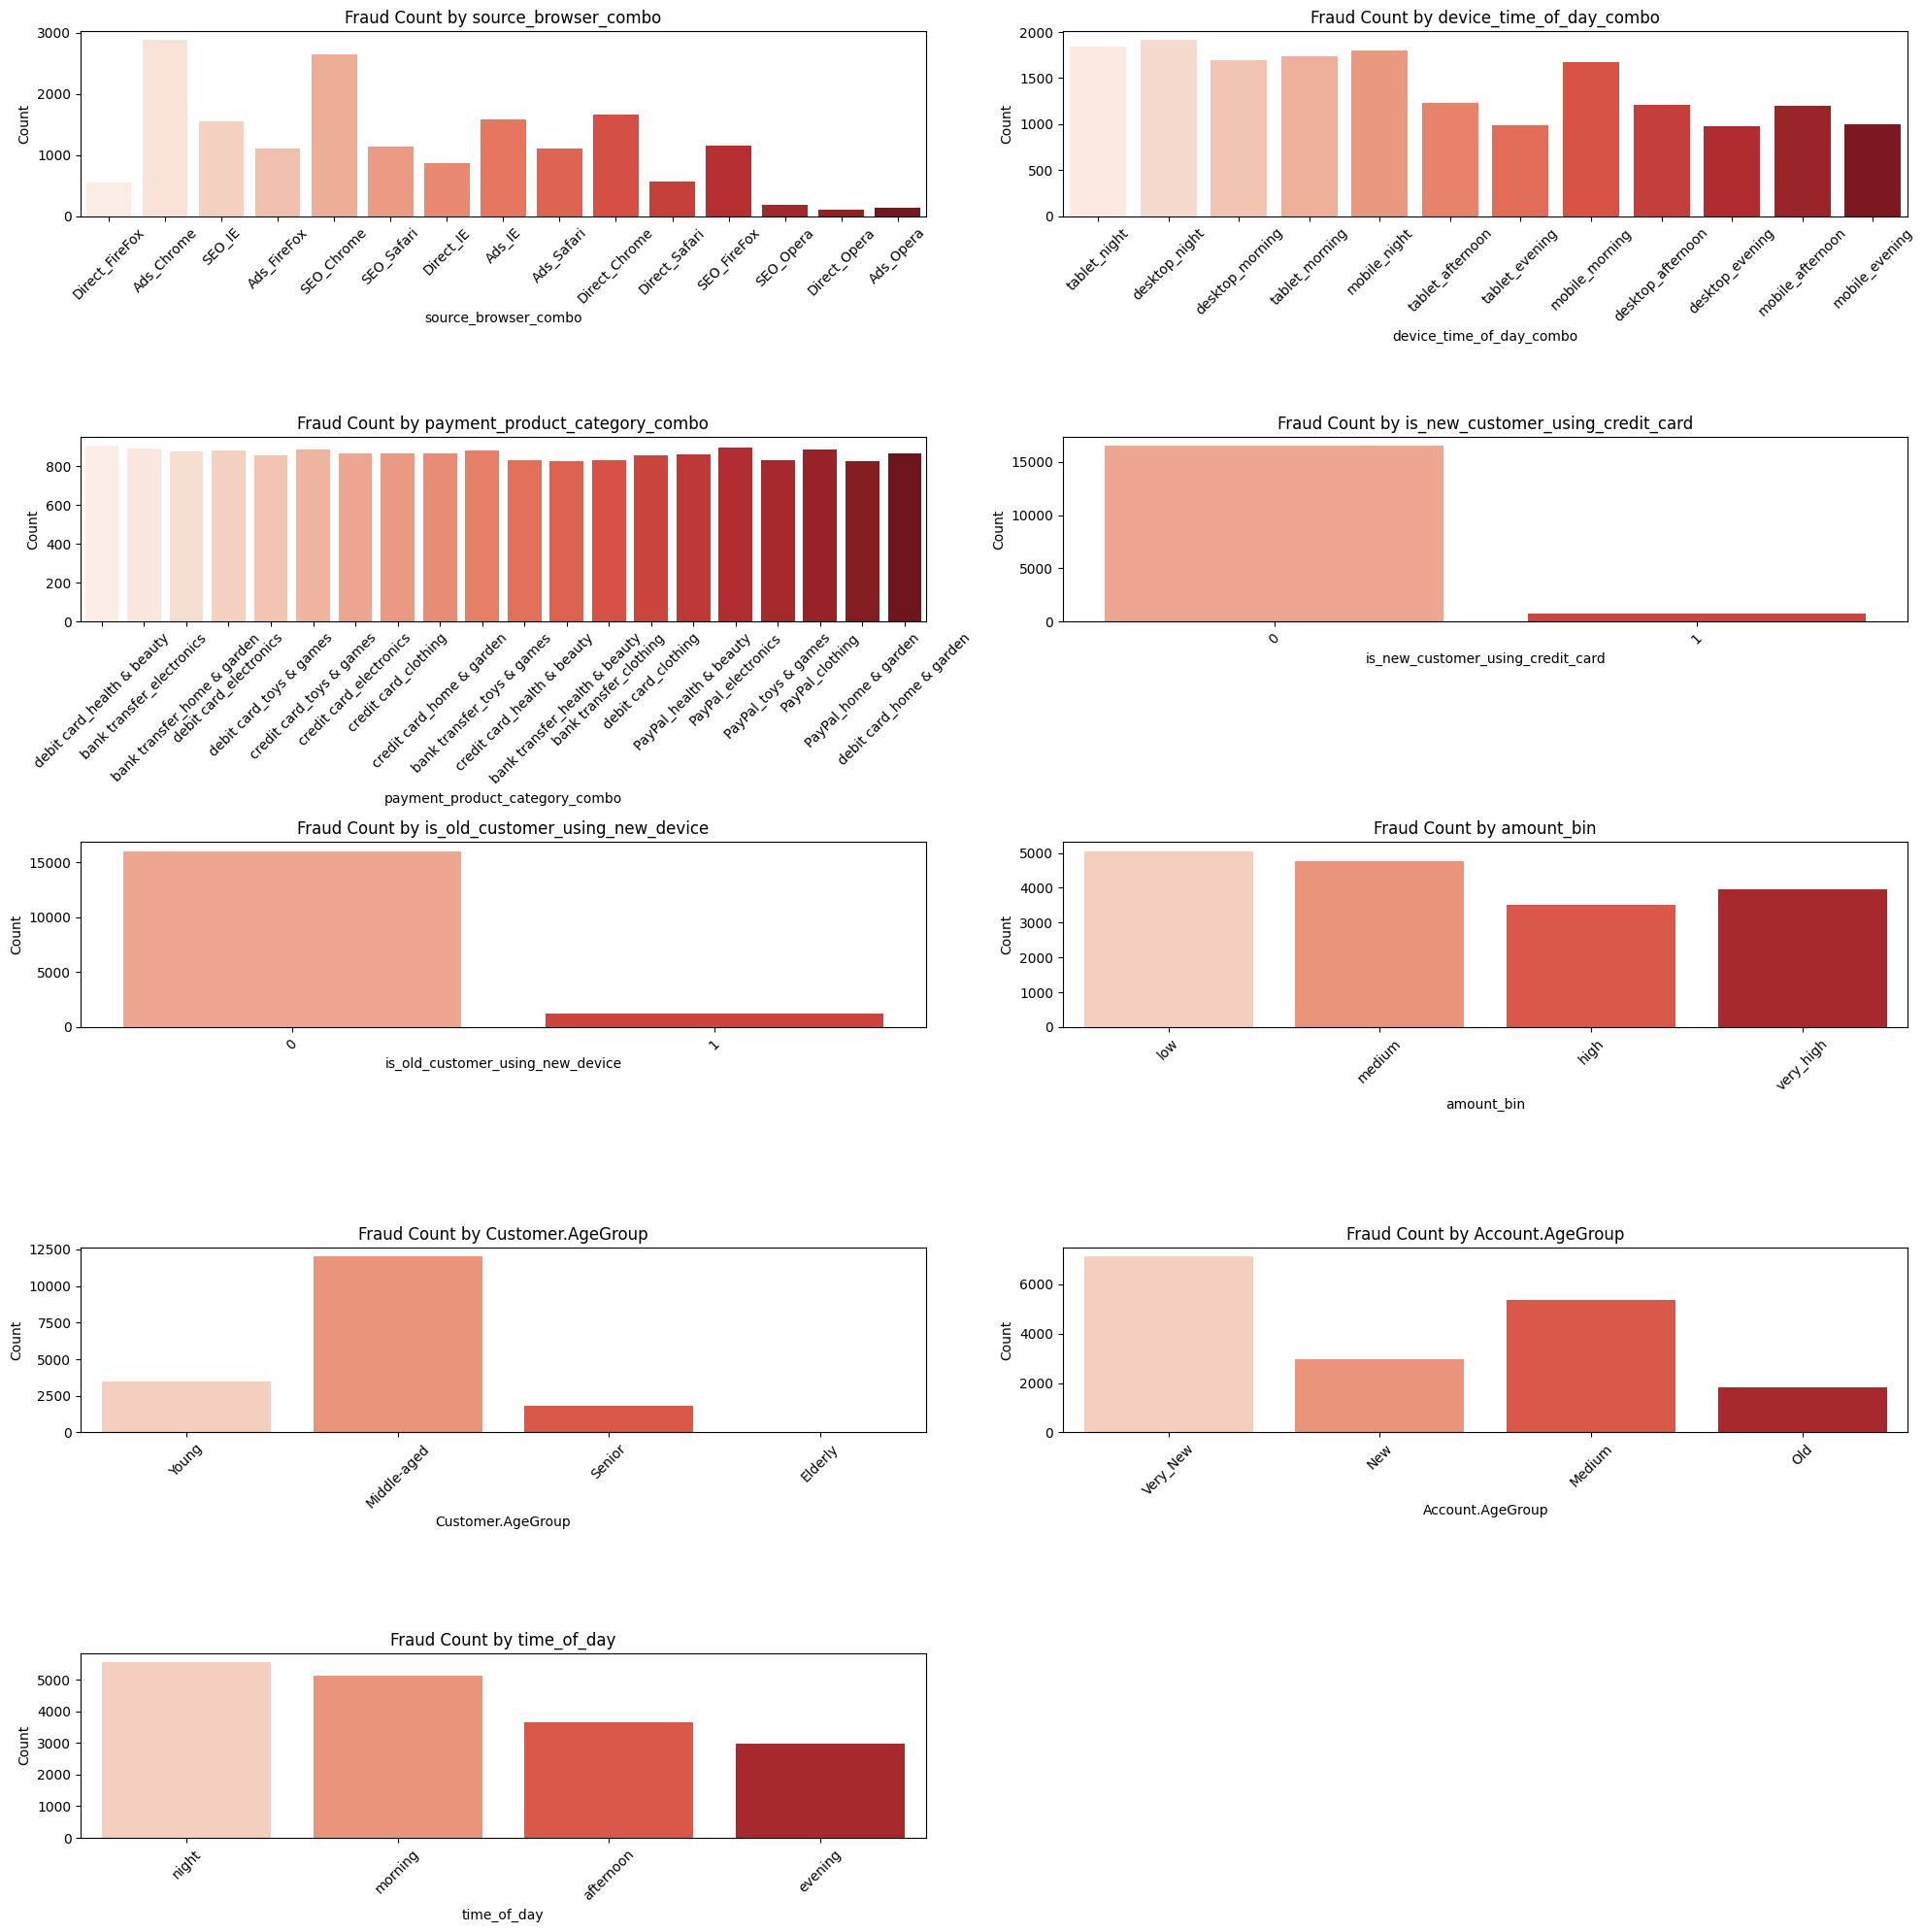

In [ ]:
#Visualising the new categroical features created to see the distribution

new_cat_cols = ['source_browser_combo', 'device_time_of_day_combo', 'payment_product_category_combo','is_new_customer_using_credit_card','is_old_customer_using_new_device','amount_bin','Customer.AgeGroup','Account.AgeGroup','time_of_day']
visualize_categorical_data(transaction_data, new_cat_cols)

In [ ]:
#Checking transaction frequency in month, year and year-month combined to visualise any unusual event

print(transaction_data.groupby('transaction_year').size(),'\n')

print(transaction_data.groupby('transaction_month').size(),'\n')

print(transaction_data.groupby(['transaction_month','transaction_year']).size())

transaction_year
2015    119911
2024    120066
dtype: int64 

transaction_month
1     47867
2     42875
3     49137
4     16066
5     15330
6     14836
7     15526
8     14896
9     11379
10     7826
11     3781
12      458
dtype: int64 

transaction_month  transaction_year
1                  2015                 8048
                   2024                39819
2                  2015                 5122
                   2024                37753
3                  2015                 9610
                   2024                39527
4                  2015                13099
                   2024                 2967
5                  2015                15330
6                  2015                14836
7                  2015                15526
8                  2015                14896
9                  2015                11379
10                 2015                 7826
11                 2015                 3781
12                 2015                  458
dtype

**Concurrency Features:** Added new features to capture the number of transactions occurring within specified rolling time windows (1 minute, 5 minutes, 1 hour) based on transaction timestamps.

In [ ]:
def add_concurrency_features(df, time_windows=['1min', '5min', '1H']):
    # Ensure Transaction.Date is in datetime format
    df['Transaction.Date'] = pd.to_datetime(df['Transaction.Date'])

    # Sort data by Transaction.Date
    df = df.sort_values('Transaction.Date')

    # Set datetime index for rolling window calculations
    df = df.set_index('Transaction.Date')

    for window in time_windows:
        # Count transactions within each time window
        df[f'Concurrent_Transactions_{window}'] = (
            df['Transaction.Amount']
            .rolling(window=window, min_periods=1)
            .count()
        )

    # Reset index to keep Transaction.Date as a column
    df = df.reset_index()

    return df


transaction_data = add_concurrency_features(transaction_data)

### Visualizing Concurrency Features

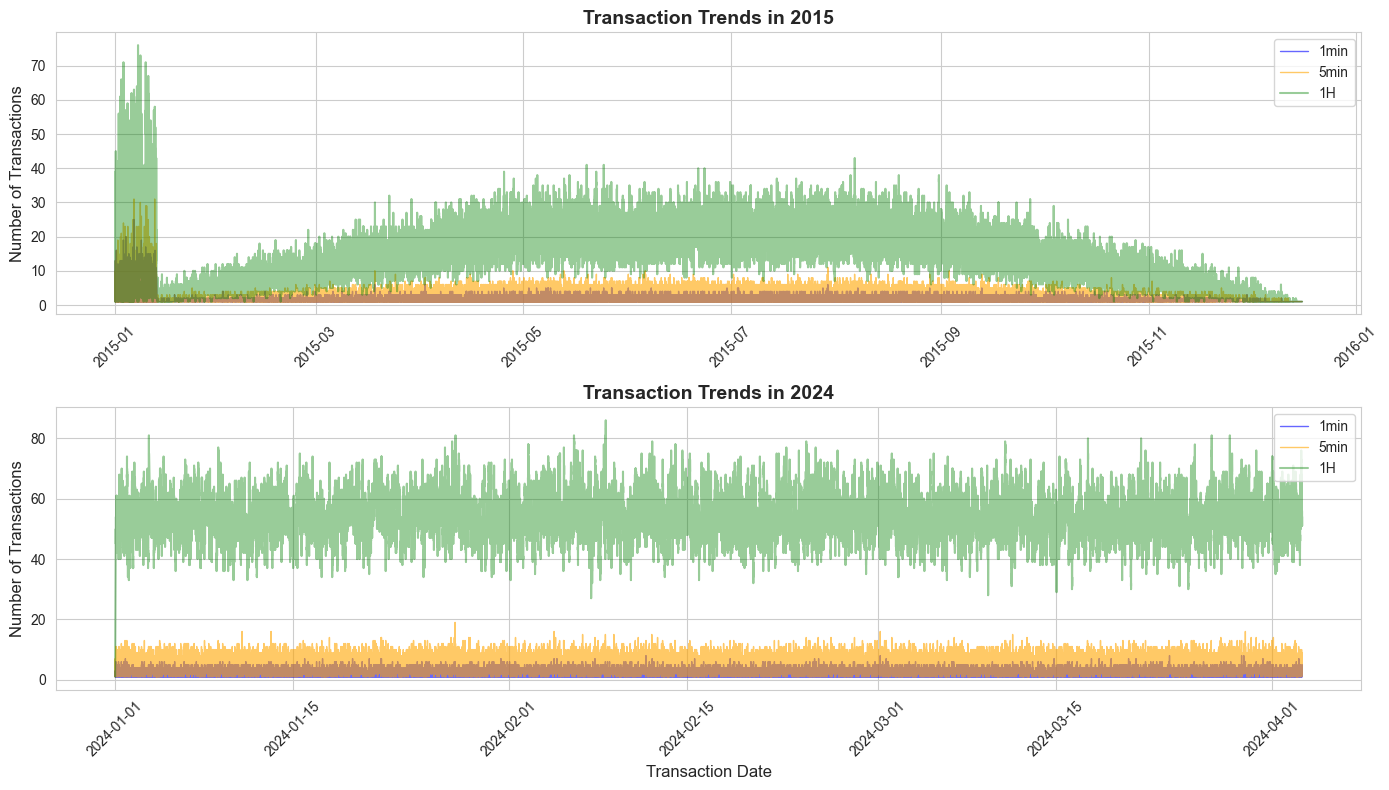

In [ ]:

sns.set_style("whitegrid")

# Define figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=False)

# Filter 2015 and 2024 data separately
data_2015 = transaction_data[transaction_data['Transaction.Date'].dt.year == 2015]
data_2024 = transaction_data[transaction_data['Transaction.Date'].dt.year == 2024]

# Colors for each line
colors = {'1min': 'blue', '5min': 'orange', '1H': 'green'}

# Plot 2015 transactions
axes[0].plot(data_2015['Transaction.Date'], data_2015['Concurrent_Transactions_1min'],
             label='1min', color=colors['1min'], alpha=0.6, linewidth=1)
axes[0].plot(data_2015['Transaction.Date'], data_2015['Concurrent_Transactions_5min'],
             label='5min', color=colors['5min'], alpha=0.6, linewidth=1)
axes[0].plot(data_2015['Transaction.Date'], data_2015['Concurrent_Transactions_1H'],
             label='1H', color=colors['1H'], alpha=0.4, linewidth=1.5)

axes[0].set_title("Transaction Trends in 2015", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Number of Transactions", fontsize=12)
axes[0].legend(fontsize=10)

# Plot 2024 transactions
axes[1].plot(data_2024['Transaction.Date'], data_2024['Concurrent_Transactions_1min'],
             label='1min', color=colors['1min'], alpha=0.6, linewidth=1)
axes[1].plot(data_2024['Transaction.Date'], data_2024['Concurrent_Transactions_5min'],
             label='5min', color=colors['5min'], alpha=0.6, linewidth=1)
axes[1].plot(data_2024['Transaction.Date'], data_2024['Concurrent_Transactions_1H'],
             label='1H', color=colors['1H'], alpha=0.4, linewidth=1.5)

axes[1].set_title("Transaction Trends in 2024", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Transaction Date", fontsize=12)
axes[1].set_ylabel("Number of Transactions", fontsize=12)
axes[1].legend(fontsize=10)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
#Checking any new missing values

transaction_data.isnull().sum()

Transaction.Date                     0
Transaction.Amount                   0
Customer.Age                         0
Account.Age.Days                     0
Transaction.Hour                     0
source                               0
browser                              0
Payment.Method                       0
Product.Category                     0
Quantity                             0
Device.Used                          0
Is.Fraudulent                        0
transaction_date                     0
transaction_time                     0
transaction_day                      0
transaction_year                     0
transaction_week                     0
transaction_month                    0
day_of_week                          0
is_weekend                           0
time_of_day                          0
late_night                           0
amount_bin                           0
Customer.AgeGroup                    0
Account.AgeGroup                     0
source_browser_combo     

# Handling Categorical Features Using Label-Encoding and Target-Encoding

We used label encoding for low-cardinality categorical features to ensure consistency across the model. As, one-hot encoding increased the dimensions which led to poor performance. For models like decision trees or random forests, one-hot encoding can make splits less efficient. Also, tree-based models don't treat the encoded values as ordinal.





In [ ]:
cat_cols_labels = ['source', 'browser', 'Payment.Method', 'Product.Category', 'Device.Used',
                'time_of_day', 'amount_bin', 'Customer.AgeGroup','Account.AgeGroup','source_browser_combo','device_time_of_day_combo','payment_product_category_combo']

# Count unique values for each categorical column
unique_counts = transaction_data[cat_cols_labels].nunique()

# Print the unique value counts
print(unique_counts)

source                             3
browser                            5
Payment.Method                     4
Product.Category                   5
Device.Used                        3
time_of_day                        4
amount_bin                         4
Customer.AgeGroup                  4
Account.AgeGroup                   4
source_browser_combo              15
device_time_of_day_combo          12
payment_product_category_combo    20
dtype: int64


### Using label encoding on below given categorigcal features:  
source, browser, Payment.Method, Device.Used, time_of_day, amount_bin, Customer.AgeGroup, Account.AgeGroup

In [ ]:
def label_encode_features(df):
    cat_cols_labels = ['source', 'browser', 'Payment.Method', 'Product.Category', 'Device.Used',
                'time_of_day', 'amount_bin', 'Customer.AgeGroup','Account.AgeGroup']
    le_dict = {}

    for col in cat_cols_labels:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le

    return df, le_dict

transaction_data, label_encoders = label_encode_features(transaction_data)
transaction_data.dtypes


Transaction.Date                     datetime64[ns]
Transaction.Amount                          float64
Customer.Age                                  int64
Account.Age.Days                              int64
Transaction.Hour                              int64
source                                        int64
browser                                       int64
Payment.Method                                int64
Product.Category                              int64
Quantity                                      int64
Device.Used                                   int64
Is.Fraudulent                                 int64
transaction_date                             object
transaction_time                             object
transaction_day                               int64
transaction_year                              int64
transaction_week                             UInt32
transaction_month                             int64
day_of_week                                 float64
is_weekend  

### Using target encoding on below given categorical features as its unique value count is > 10:

source_browser_combo, device_time_of_day_combo, payment_product_category_combo

In [ ]:
def target_encode_features(df, target_col):
  target_cols = ['source_browser_combo', 'device_time_of_day_combo', 'payment_product_category_combo']
  # Initialize Target Encoder
  encoder = TargetEncoder(cols=target_cols)

  df[target_cols] = encoder.fit_transform(df[target_cols],df[target_col])

  return df

transaction_data = target_encode_features(transaction_data, 'Is.Fraudulent')

In [ ]:
transaction_data.dtypes

Transaction.Date                     datetime64[ns]
Transaction.Amount                          float64
Customer.Age                                  int64
Account.Age.Days                              int64
Transaction.Hour                              int64
source                                        int64
browser                                       int64
Payment.Method                                int64
Product.Category                              int64
Quantity                                      int64
Device.Used                                   int64
Is.Fraudulent                                 int64
transaction_date                             object
transaction_time                             object
transaction_day                               int64
transaction_year                              int64
transaction_week                             UInt32
transaction_month                             int64
day_of_week                                 float64
is_weekend  

### Eliminating Datetime Columns as model only accept numerical values

In [ ]:
# Convert or drop any remaining datetime columns
for col in transaction_data.columns:
    if transaction_data[col].dtype == 'datetime64[ns]' or isinstance(transaction_data[col].iloc[0], (datetime.date, datetime.datetime)):
        print(f"Dropping datetime column: {col}")
        transaction_data = transaction_data.drop(columns=col)

for col in transaction_data.columns:
    if isinstance(transaction_data[col].iloc[0], datetime.time):
        transaction_data.drop(columns=[col], inplace=True)


Dropping datetime column: Transaction.Date
Dropping datetime column: transaction_date


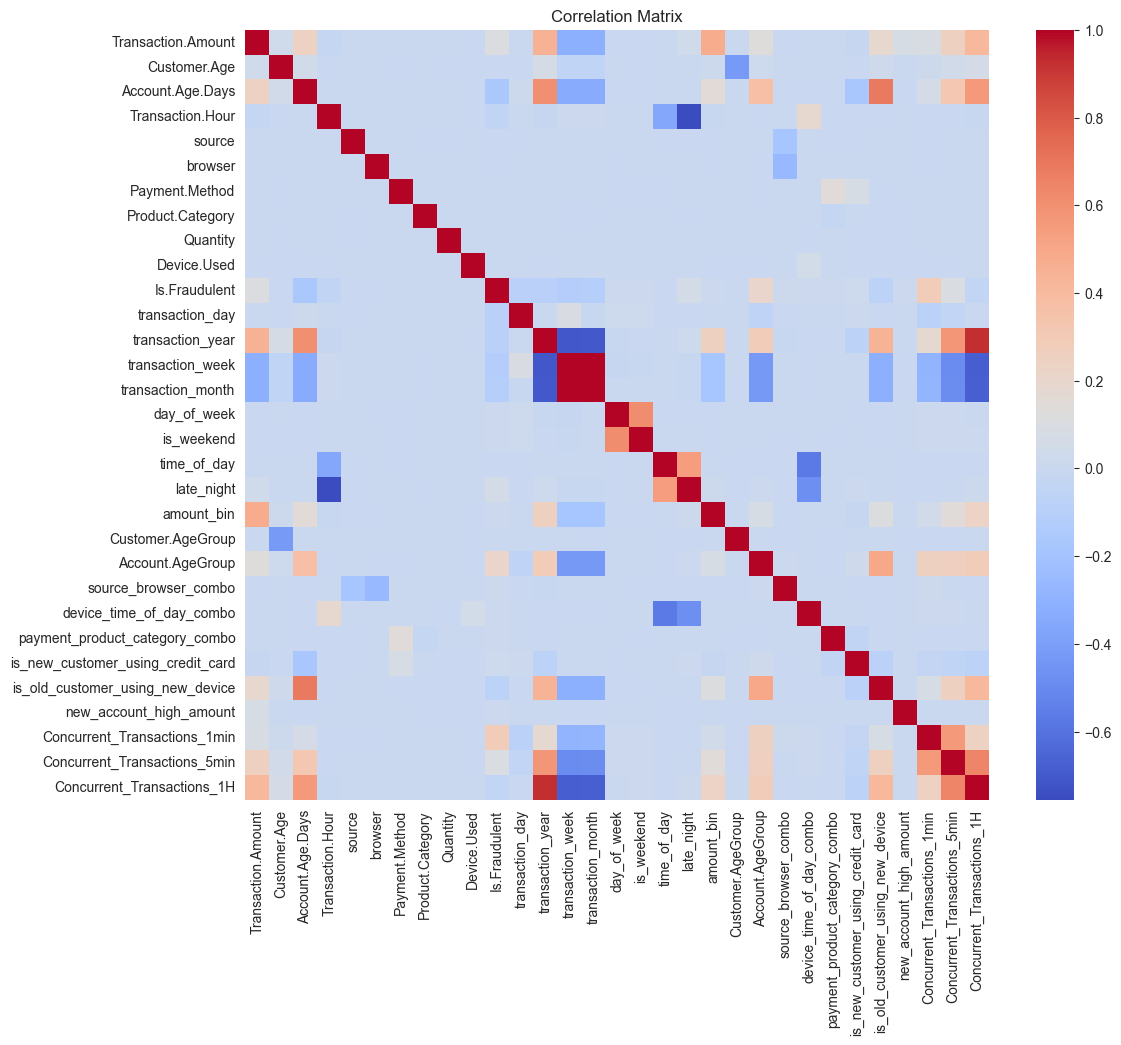

In [ ]:
# Displaying Correlation Matrix

def corr(df):
  # Plot a correlation matrix for numeric features
  plt.figure(figsize=(12,10))
  # Calculate correlations only for numerical features
  num_df = df.select_dtypes(include=np.number)
  sns.heatmap(num_df.corr(), annot=False, fmt='.2f', cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.show()

corr(transaction_data)

In [ ]:
#Creating a function to show correlation between variables as from heatmap its not clearly visible due to high no. of variables

def higher_corr_values(df):
    numeric_df = transaction_data.select_dtypes(include=np.number)

    correlation_matrix = numeric_df.corr()

    # Filter correlations greater than 0.6 (excluding self-correlation)
    filtered_corr = correlation_matrix[(correlation_matrix.abs() > 0.6) & (correlation_matrix != 1.0)]

    # Remove fully NaN rows/columns (no significant correlation)
    filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')

    # Display as DataFrame with better formatting
    filtered_corr.style.background_gradient(cmap="coolwarm").format("{:.2f}")

    return filtered_corr

higher_corr_values(transaction_data)


,Account.Age.Days,Transaction.Hour,transaction_year,transaction_week,transaction_month,day_of_week,is_weekend,late_night,is_old_customer_using_new_device,Concurrent_Transactions_5min,Concurrent_Transactions_1H
Account.Age.Days,NaN,NaN,0.608737,NaN,NaN,NaN,NaN,NaN,0.684796,NaN,NaN
Transaction.Hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.755358,NaN,NaN,NaN
transaction_year,0.608737,NaN,NaN,-0.709947,-0.707236,NaN,NaN,NaN,NaN,NaN,0.927361
transaction_week,NaN,NaN,-0.709947,NaN,0.994454,NaN,NaN,NaN,NaN,NaN,-0.683401
transaction_month,NaN,NaN,-0.707236,0.994454,NaN,NaN,NaN,NaN,NaN,NaN,-0.679899
day_of_week,NaN,NaN,NaN,NaN,NaN,NaN,0.615195,NaN,NaN,NaN,NaN
is_weekend,NaN,NaN,NaN,NaN,NaN,0.615195,NaN,NaN,NaN,NaN,NaN
late_night,NaN,-0.755358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_old_customer_using_new_device,0.684796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concurrent_Transactions_5min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.646999


### Dropping Highly Correlated Features

In [ ]:
transaction_data = transaction_data.drop(columns = ['transaction_year','transaction_month','source','Payment.Method','Device.Used','late_night'])

In [ ]:
transaction_data.columns

Index(['Transaction.Amount', 'Customer.Age', 'Account.Age.Days',
       'Transaction.Hour', 'browser', 'Product.Category', 'Quantity',
       'Is.Fraudulent', 'transaction_day', 'transaction_week', 'day_of_week',
       'is_weekend', 'time_of_day', 'amount_bin', 'Customer.AgeGroup',
       'Account.AgeGroup', 'source_browser_combo', 'device_time_of_day_combo',
       'payment_product_category_combo', 'is_new_customer_using_credit_card',
       'is_old_customer_using_new_device', 'new_account_high_amount',
       'Concurrent_Transactions_1min', 'Concurrent_Transactions_5min',
       'Concurrent_Transactions_1H'],
      dtype='object')

In [ ]:
# Checking once if there are any higher correlated features left

higher_corr_values(transaction_data)

,Account.Age.Days,transaction_week,day_of_week,is_weekend,is_old_customer_using_new_device,Concurrent_Transactions_5min,Concurrent_Transactions_1H
Account.Age.Days,NaN,NaN,NaN,NaN,0.684796,NaN,NaN
transaction_week,NaN,NaN,NaN,NaN,NaN,NaN,-0.683401
day_of_week,NaN,NaN,NaN,0.615195,NaN,NaN,NaN
is_weekend,NaN,NaN,0.615195,NaN,NaN,NaN,NaN
is_old_customer_using_new_device,0.684796,NaN,NaN,NaN,NaN,NaN,NaN
Concurrent_Transactions_5min,NaN,NaN,NaN,NaN,NaN,NaN,0.646999
Concurrent_Transactions_1H,NaN,-0.683401,NaN,NaN,NaN,0.646999,NaN


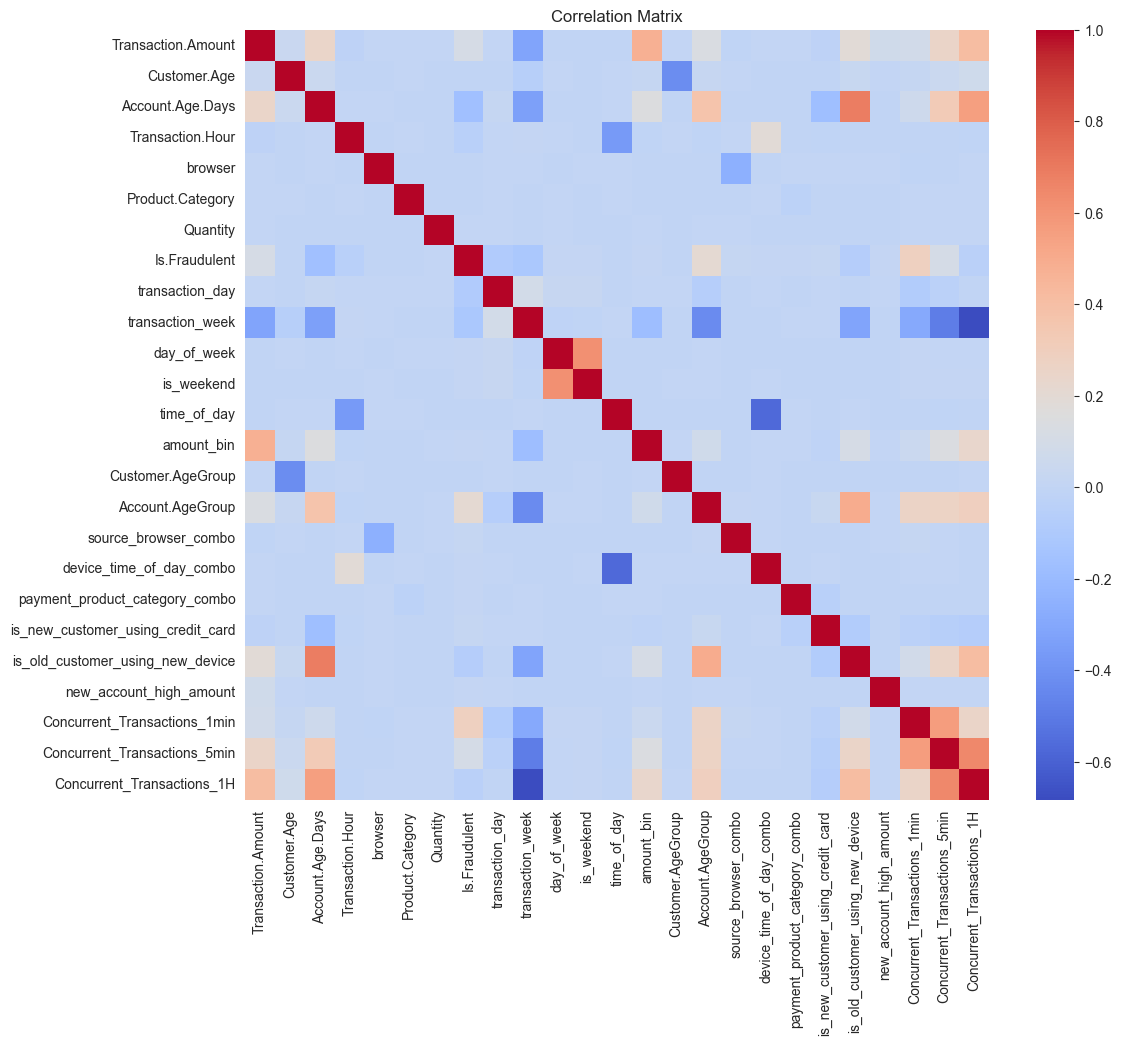

In [ ]:
corr(transaction_data)

# Splitting Data into Features and Target

In [ ]:
def split_data(df, target_col):
  features_to_drop = [target_col]
  if 'Transaction.ID' in df.columns:
      features_to_drop.append('Transaction.ID')

  X = df.drop(columns=features_to_drop, errors='ignore')
  y = df[target_col]
  return X, y

X, y = split_data(transaction_data, 'Is.Fraudulent')


### SMOTE Analysis

Handling class imbalance using SMOTE (Synthetic Minority Over-sampling Technique), splitting the data into training, validation, and test sets, scaling the features, and visualizing the class distribution before and after applying SMOTE to training data.

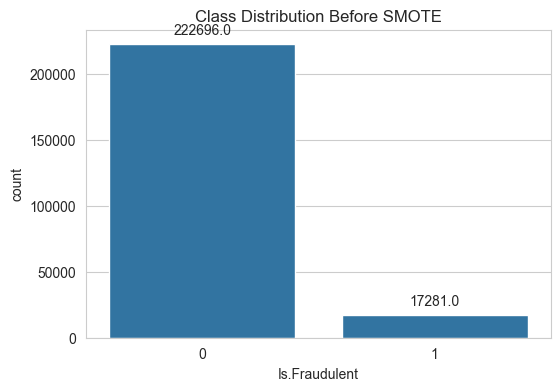

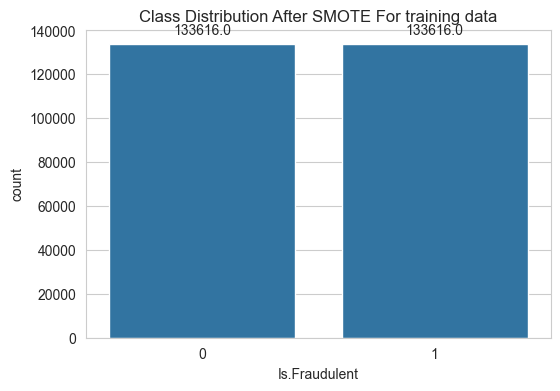

In [ ]:
def handle_class_imbalance(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """
    Handles class imbalance using SMOTE and visualizes the class distribution before & after SMOTE.

    Parameters:
    X: features
    y: target


    Returns:
    X_train_res (pd.DataFrame): Resampled training features.
    y_train_res (pd.Series): Resampled training target.
    X_val (pd.DataFrame): Resampled validating features.
    y_val (pd.Series): Resampled validating target.
    X_test (pd.DataFrame): Test set features.
    y_test (pd.Series): Test set target.
    """


    # Visualize class distribution before SMOTE
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=y)
    plt.title('Class Distribution Before SMOTE')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.show()

    # # Split into training, validation and test sets

    # # First Split: Train+Val and Test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # # Second Split: Train and Validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size / (1 - test_size),
                                                      random_state=random_state, stratify=y_train_val)


    # Applying scaler

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    # Transform validation and test sets using the same scaler
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Applying SMOTE
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

    # Visualize class distribution after SMOTE
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=y_train_res)
    plt.title('Class Distribution After SMOTE For training data')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.show()

    return X_train_res, y_train_res, X_val_scaled, y_val, X_test_scaled, y_test



X_train_res, y_train_res, X_val, y_val, X_test, y_test = handle_class_imbalance(X, y, test_size=0.2, val_size=0.2)


# Model Selection, Training and Performance Evaluation

In [ ]:
# Selected 7 models based on classification problem to see their relative perfomance

# Define classifiers
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42)
}


# Dictionary to store evaluation metrics
results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print('-'*40)

print('Evaluation Metrics:')
print(pd.DataFrame(results).T)

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     44540
           1       0.21      0.62      0.31      3456

    accuracy                           0.80     47996
   macro avg       0.59      0.72      0.60     47996
weighted avg       0.91      0.80      0.84     47996

----------------------------------------
Model: KNN
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     44540
           1       0.19      0.58      0.28      3456

    accuracy                           0.79     47996
   macro avg       0.57      0.69      0.58     47996
weighted avg       0.91      0.79      0.83     47996

----------------------------------------
Model: DecisionTree
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     44540
           1       0.40      0.52      0.45      3456

    accuracy                           0.91

In [ ]:
#Checking feature importance of best 3 models

def check_feature_importance(X, y, test_size=0.2, val_size=0.2, random_state=42):

    # # First Split: Train+Val and Test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # # Second Split: Train and Validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size / (1 - test_size),
                                                      random_state=random_state, stratify=y_train_val)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Transform validation and test sets using the same scaler
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
    # Define classifiers
    shortlisted_models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
        'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42)
    }



    for name, model in shortlisted_models.items():
        model.fit(X_train_res, y_train_res)
        feature_importance = dict(zip(X_train.columns, model.feature_importances_))

        # Print comparison
        print(f"Feature Importance of {name}:")
        for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
            print(f"{feature}: {importance:.4f}")

        print('\n')


check_feature_importance(X,y)

Feature Importance of RandomForest:
Account.Age.Days: 0.1306
Concurrent_Transactions_1min: 0.0915
Account.AgeGroup: 0.0761
Concurrent_Transactions_5min: 0.0754
transaction_week: 0.0739
Transaction.Amount: 0.0558
Transaction.Hour: 0.0543
amount_bin: 0.0529
Product.Category: 0.0460
Quantity: 0.0455
browser: 0.0373
device_time_of_day_combo: 0.0367
day_of_week: 0.0352
Concurrent_Transactions_1H: 0.0340
source_browser_combo: 0.0338
transaction_day: 0.0329
time_of_day: 0.0267
payment_product_category_combo: 0.0257
Customer.Age: 0.0205
is_old_customer_using_new_device: 0.0059
Customer.AgeGroup: 0.0053
is_weekend: 0.0021
is_new_customer_using_credit_card: 0.0017
new_account_high_amount: 0.0000


Feature Importance of XGBoost:
Product.Category: 0.1330
Quantity: 0.1279
Account.Age.Days: 0.1128
Account.AgeGroup: 0.0881
amount_bin: 0.0712
Concurrent_Transactions_1min: 0.0682
day_of_week: 0.0662
Concurrent_Transactions_5min: 0.0516
time_of_day: 0.0506
browser: 0.0429
source_browser_combo: 0.0414
Tr

### Feature Selection

Selecting high-importance features based on the analysis of shortlisted models.

In [ ]:
#Dropping common least important features from best 3 models

transaction_data = transaction_data.drop(columns= ['is_weekend', 'is_old_customer_using_new_device',
                                                   'is_new_customer_using_credit_card', 'new_account_high_amount'])

In [ ]:
X, y = split_data(transaction_data, 'Is.Fraudulent')

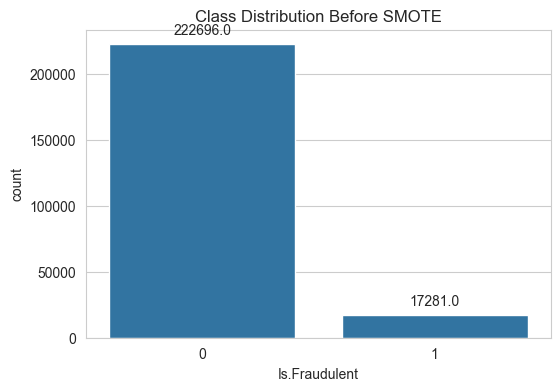

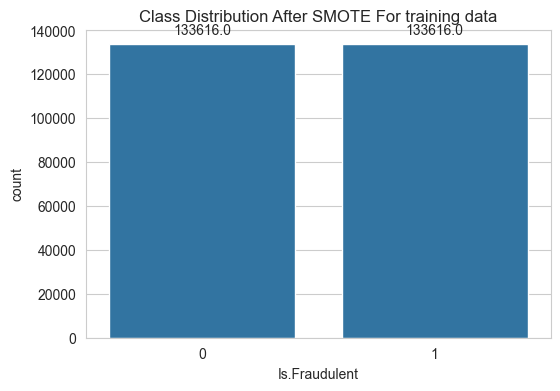

In [ ]:
X_train_res, y_train_res, X_val, y_val, X_test, y_test = handle_class_imbalance(X, y, test_size=0.2, val_size=0.2)


### Evaluating the Selected Model

Removing less important features based on feature importance may not always improve the score, but it helps make the model simpler, more efficient, and reduces noise or multicollinearity.

In [ ]:
#Re-evaluating model on important feature selected

# Define classifiers
shortlisted_models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42)
}


# Dictionary to store evaluation metrics
new_results = {}

for name, model in shortlisted_models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    new_results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print('-'*40)

print('Evaluation Metrics:')
print(pd.DataFrame(new_results).T)

Model: RandomForest
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     44540
           1       0.93      0.47      0.63      3456

    accuracy                           0.96     47996
   macro avg       0.95      0.74      0.80     47996
weighted avg       0.96      0.96      0.95     47996

----------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     44540
           1       0.97      0.47      0.64      3456

    accuracy                           0.96     47996
   macro avg       0.96      0.74      0.81     47996
weighted avg       0.96      0.96      0.95     47996

----------------------------------------
[LightGBM] [Info] Number of positive: 133616, number of negative: 133616
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010125 seconds.
You can set `force_col_wise=true` to remove the over

In [ ]:
print(transaction_data.columns)

Index(['Transaction.Amount', 'Customer.Age', 'Account.Age.Days',
       'Transaction.Hour', 'browser', 'Product.Category', 'Quantity',
       'Is.Fraudulent', 'transaction_day', 'transaction_week', 'day_of_week',
       'time_of_day', 'amount_bin', 'Customer.AgeGroup', 'Account.AgeGroup',
       'source_browser_combo', 'device_time_of_day_combo',
       'payment_product_category_combo', 'Concurrent_Transactions_1min',
       'Concurrent_Transactions_5min', 'Concurrent_Transactions_1H'],
      dtype='object')


### Hyper-parameter Tuning

In [ ]:
# Define parameter grids
param_grids = {
    'RandomForest' : {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [None, 2, 5, 10],
    'min_samples_leaf': [None, 1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, 9],
        'colsample_bytree': [0.5, 0.7, 1.0],
        'subsample': [0.5, 0.7, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'num_leaves': [31, 50, 100],
        'colsample_bytree': [0.5, 0.7, 1.0],
        'subsample': [0.5, 0.7, 1.0]
    }
}



tuned_results = {}
best_models = {}

# Perform RandomizedSearchCV for each model
for name, model in shortlisted_models.items():
    print(f"Tuning {name}...")
    random_search = RandomizedSearchCV(model, param_distributions=param_grids[name],
                                       n_iter=10, scoring='f1', cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train_res, y_train_res)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    tuned_results[name] = f1
    best_models[name] = best_model
    print(f"Tuned {name} F1 Score: {f1:.4f}")


# Identify best model based on F1 Score
best_model_name = max(tuned_results, key=tuned_results.get)
print(f"\nBest model based on F1 Score: {best_model_name} with F1 Score: {tuned_results[best_model_name]:.4f}")


Tuning RandomForest...
Tuned RandomForest F1 Score: 0.6297
Tuning XGBoost...
Tuned XGBoost F1 Score: 0.6355
Tuning LightGBM...
[LightGBM] [Info] Number of positive: 133616, number of negative: 133616
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 267232, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Tuned LightGBM F1 Score: 0.6355

Best model based on F1 Score: XGBoost with F1 Score: 0.6355


In [ ]:
best_models

{'RandomForest': RandomForestClassifier(min_samples_split=10, n_estimators=500, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.2, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, ...),
 'LightGBM': LGBMClassifier(colsample_bytree=0.7, random_state=42)}

### Evaluation of the Best Selected Model - Random Forest Classifier on Validation and Test Data

Though we are getting XGBoost as best model, but while checking the f1-score, there is not much difference between Random Forest, LightGBM and XGBoost. So, finalizing Random Forest as our best model to reduce complexity.

In [ ]:
rf_model = RandomForestClassifier(min_samples_split=10, n_estimators=500, random_state=42)
rf_model.fit(X_train_res, y_train_res)


RandomForestClassifier(min_samples_split=10, n_estimators=500, random_state=42)

In [ ]:
# Validation

y_val_pred = rf_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Precision:", precision_score(y_val, y_val_pred))
print("Validation Recall:", recall_score(y_val, y_val_pred))
print("Validation F1 Score:", f1_score(y_val, y_val_pred))


Validation Accuracy: 0.9608300691724311
Validation Precision: 0.9320175438596491
Validation Recall: 0.49189814814814814
Validation F1 Score: 0.6439393939393939


In [ ]:
# Testing

y_test_pred = rf_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))


Test Accuracy: 0.9596008000666723
Test Precision: 0.9258843346434588
Test Recall: 0.4771412037037037
Test F1 Score: 0.6297498567882376


# ROC-AUC Curve

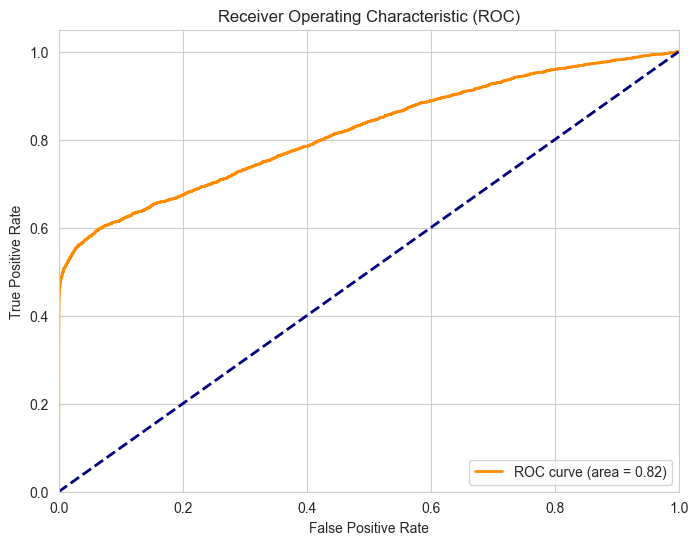

In [ ]:
# Plot ROC-AUC curve for the best model

y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Training the entire dataset and re-fitting the chosen model

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

rf_model = RandomForestClassifier(min_samples_split=10, n_estimators=500, random_state=42)
rf_model.fit(X_res, y_res)


RandomForestClassifier(min_samples_split=10, n_estimators=500, random_state=42)

In [ ]:
## Do not delete this cell ##

# export the model with pickle
import pickle

# save the model to disk

# define the filename, it should have a .pkl extension
filename = 'rf_model.pkl' # replace 'log_reg_model' with the name of your model variable

# save the model to the current directory
with open(filename, "wb") as f:
    pickle.dump(rf_model, f) # replace 'log_reg_model' with the name of your model variable


### Assessment Evaluation

This is required for the assessment to be marked. Groups should specify any data processing steps that are required to run the model in the cell below. This may include the installation of additional libraries, loading of the data, and any additional processing steps required to run the model. The model should be saved to a file called 'model.pkl' in the same directory as the notebook. The model file should be loaded and tested in the cell below to ensure it runs correctly. The model should be loaded and tested using the following code:

In [ ]:
## Do not delete this cell ##

# load the evaluation data
import pandas as pd

# load the raw data
# df_eval_raw = pd.read_csv('evaluation_dataset.csv')
df_eval_raw = pd.read_csv("student_dataset.csv")


In [ ]:
# Apply preprocessing steps to the evaluation dataset


# Importing required libraries and modules

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import warnings
warnings.filterwarnings('ignore')



# 1. Handle missing values and other required preprocessing

def impute_missing_values(df):
  for col in df.columns:
    if df[col].isnull().sum() > 0:
      if df[col].dtype.name in ['float64', 'int64', 'int32']:
          df[col].fillna(df[col].median(), inplace=True)
      else:
          df[col].fillna(df[col].mode()[0], inplace=True)
  return df

df_eval = impute_missing_values(df_eval_raw)

In [ ]:

def preprocess_data(df):

    #Time-based features

    df['Transaction.Date'] = pd.to_datetime(df['Transaction.Date'], errors='coerce')

    df['transaction_date'] = df['Transaction.Date'].dt.date
    df['transaction_time'] = df['Transaction.Date'].dt.time
    df['transaction_hour'] = df['Transaction.Date'].dt.hour
    df['transaction_day'] = df['Transaction.Date'].dt.day
    df['transaction_year'] = df['Transaction.Date'].dt.year

    if df['Transaction.Date'].notna().all():
       df['transaction_week'] = df['Transaction.Date'].dt.isocalendar().week.astype('Int64')
    else:
       df['transaction_week'] = df['Transaction.Date'].dt.isocalendar().week
    df['transaction_month'] = df['Transaction.Date'].dt.month
    df['day_of_week'] = df['Transaction.Date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x > 5 else 0)
    df[['transaction_year', 'transaction_month', 'transaction_day', 'transaction_hour']] = df[[
        'transaction_year', 'transaction_month', 'transaction_day', 'transaction_hour'
    ]].fillna(-1).astype(int)

    def time_of_day(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 21:
            return 'evening'
        else:
            return 'night'

    df['time_of_day'] = df['transaction_hour'].apply(time_of_day)
    df['late_night'] = df['Transaction.Hour'].apply(lambda x: 1 if x < 6 else 0)

    df['amount_bin'] = pd.qcut(df['Transaction.Amount'], q=4, labels=['low', 'medium', 'high', 'very_high'])
    df = df[df['Customer.Age'] >= 0]

    # Binning Customer Age into categories
    df['Customer.AgeGroup'] = pd.cut(df['Customer.Age'], bins=[-1, 25, 45, 65, 101],
                                    labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])

    # Binning Account Age
    df['Account.AgeGroup'] = pd.cut(df['Account.Age.Days'], bins=[-1, 8, 30, 180, 366],
                                    labels=['Very_New', 'New', 'Medium', 'Old'])



    df.dropna(subset=['Transaction.Date'], inplace=True)

    # Interaction Features
    df['source_browser_combo'] = df['source'] + "_" + df['browser']
    df['device_time_of_day_combo'] = df['Device.Used'] + "_" + df['time_of_day']
    df['payment_product_category_combo'] = df['Payment.Method'] + "_" + df['Product.Category']

    # # Risk-Based Features
    df['is_new_customer_using_credit_card'] = ((df['Account.AgeGroup'] == 'New') &
                                                (df['Payment.Method'] == 'credit card')).astype(int)
    df['is_old_customer_using_new_device'] = ((df['Account.AgeGroup'] == 'Old') &
                                              (df['Device.Used'] != df.groupby('Customer.Age')['Device.Used'].shift(1))).astype(int)

    df['new_account_high_amount'] = ((df['Account.Age.Days'] <= 7) & (df['Transaction.Amount'] > 6000)).astype(int)

    # Dropping the duplicate column created
    df = df.drop(columns = ['transaction_hour'])

    return df

df_eval = preprocess_data(df_eval_raw)


In [ ]:
def add_concurrency_features(df, time_windows=['1min', '5min', '1H']):
    # Ensure Transaction.Date is in datetime format
    df['Transaction.Date'] = pd.to_datetime(df['Transaction.Date'], errors='coerce')

    # Sort data by Transaction.Date
    df = df.sort_values('Transaction.Date')

    # Set datetime index for rolling window calculations
    df = df.set_index('Transaction.Date')

    for window in time_windows:
        # Count transactions within each time window
        df[f'Concurrent_Transactions_{window}'] = (
            df['Transaction.Amount']
            .rolling(window=window, min_periods=1)
            .count()
        )

    # Reset index to keep Transaction.Date as a column
    df = df.reset_index()

    return df

# Apply the function
df_eval = add_concurrency_features(df_eval)

In [ ]:
def label_encode_features(df):
    cat_cols_labels = ['source', 'browser', 'Payment.Method', 'Product.Category', 'Device.Used',
                'time_of_day', 'amount_bin', 'Customer.AgeGroup','Account.AgeGroup']
    le_dict = {}

    for col in cat_cols_labels:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le

    return df, le_dict

df_eval, label_encoders = label_encode_features(df_eval)

In [ ]:
def target_encode_features(df, target_col):
  target_cols = ['source_browser_combo', 'device_time_of_day_combo', 'payment_product_category_combo']
  # Initialize Target Encoder
  encoder = TargetEncoder(cols=target_cols)

  df[target_cols] = encoder.fit_transform(df[target_cols],df[target_col])

  return df

df_eval = target_encode_features(df_eval, 'Is.Fraudulent')

In [ ]:
# Convert or drop any remaining datetime columns
for col in df_eval.columns:
    if df_eval[col].dtype == 'datetime64[ns]' or isinstance(df_eval[col].iloc[0], (datetime.date, datetime.datetime)):
        df_eval = df_eval.drop(columns=col)

for col in df_eval.columns:
    if isinstance(df_eval[col].iloc[0], datetime.time):
        df_eval.drop(columns=[col], inplace=True)

In [ ]:
# Drop columns that were used for feature extraction but aren't needed for prediction
df_eval.drop(columns=['transaction_year','transaction_month','source','Payment.Method','Device.Used','late_night','is_weekend', 'is_old_customer_using_new_device',
                                                   'is_new_customer_using_credit_card', 'new_account_high_amount'], inplace=True, errors='ignore')


In [ ]:
def split_data(df, target_col):
  features_to_drop = [target_col]
  if 'Transaction.ID' in df.columns:
      features_to_drop.append('Transaction.ID')

  X = df.drop(columns=features_to_drop, errors='ignore')
  y = df[target_col]
  return X, y

X, y = split_data(df_eval, 'Is.Fraudulent')
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
## Do not delete this cell ##

# Load the model and evaluate it on the evaluation data

# Load the pickle model
with open('rf_model.pkl', "rb") as f:
    eval_model = pickle.load(f) # Load the trained model

# Predict on the evaluation dataset


y_eval = eval_model.predict(X_scaled)

# Calculate the F1 score
from sklearn.metrics import f1_score
f1_eval = f1_score(y, y_eval)

# Print the F1 score
print(f'F1 Score: {f1_eval:.3f}')


F1 Score: 0.777


# **Reflective Summary**

The assigned task involved analysing and detecting fraudulent transactions. For this classification task in Part 1 with an F1 score of 0.55, we analysed transaction dataset and explored the data mining process which included steps such as data preprocessing, exploratory data analysis to better understand fraud patterns, feature engineering and handled class imbalance. We implemented different models to select an appropriate model based on its performance and suitability for the given task. Further, in Part 2, for model improvement, we focused on adding more features, ranked these attributes with feature importance and also utilised hyperparameter tuning to build a robust model capable of handling the task of fraud detection.

## Preprocessing Techniques Implemented:

Since this is a fraud detection model, timestamp-based features are crucial in identifying suspicious patterns. We derived multiple time-based features, such as transaction hour, day, week, month, year, and time of day categories. These features help to capture trends in fraudulent activity, as certain timeframes are more prone to fraud. The dataset includes source, browser, and device type, as well as key fraud indicators; we leveraged them to create interaction features that combine these categorical variables. Since customer ID and transaction ID are absent in the dataset, we used a combination of customer age and account age to approximate user identification, enabling the detection of behavioural inconsistencies. Further, we introduced risk-based features such as identifying new customers making high-value transactions and old customers using new devices—commonly associated with fraudulent activities.
Data visualization, including box plots and trend analysis, guided additional feature engineering. The analysis showed that outliers in transaction amounts were often linked to fraud transactions, meaning that removing them would limit the model’s ability to detect fraudulent patterns. Instead, we handled these outliers by binning transaction amounts and age groups to preserve the integrity of the fraud signals.
These preprocessing techniques were implemented to enhance the model's efficiency, ensuring that it generalizes well to real-world fraud detection scenarios.

## Model Selection & Evaluation:

Detecting fraudulent transactions was an interesting problem due to the highly skewed nature of data where fraudulent transactions only represented a small fraction of all transactions. Traditional models often struggle with this imbalance with a bias towards the majority class, to mitigate this we applied SMOTE to artificially balance the class. Even with this adjustment we found that many models tend to either overfit or fail to generalise well. After testing different models, Random Forest provided the best balance of accuracy and robustness, thanks to its ensemble learning approach and ability to capture complex, non-linear relationships in transaction patterns. Unlike linear models, it effectively identified subtle fraud indicators that don’t follow predictable rules. Feature importance analysis further refined the model and improved fraud detection.
Upon improvement in model from Part 1, we achieved 93% precision on both validation and test sets, meaning most flagged transactions were actual frauds. This is crucial in real-world applications, where false positives can block legitimate transactions and inconvenience customers. However, recall remained at 47-49%, meaning some fraudulent transactions were missed. While a higher recall would be ideal, fraud detection requires a trade-off between catching fraud and avoiding excessive false alarms. Our F1 score of 64% on validation and 62% on the test set reflected this balance, making it our most effective model.
Looking back, Random Forest proved to be a reliable choice for fraud detection. While there is room for improvement, this experience reinforced the importance of selecting models that are both effective and practical for real-world applications.

## Alternative Models Considered:

We evaluated LightGBM (LGBM), XGBoost, and Random Forest, as they are well-suited for classification and handling imbalanced datasets. LGBM and XGBoost, known for their high accuracy, were considered due to their ability to capture complex relationships. However, they required extensive hyperparameter tuning and were more sensitive to noisy data. Explainability was a key factor in choosing Random Forest over XGBoost. While XGBoost had a slightly higher score, Random Forest provided better interpretability, making it easier to analyse feature importance and understand the decision-making process. While boosting models performed well in the base model, Random Forest is well-suited for handling large datasets and imbalanced classification problems. Given its stability, interpretability, and strong fraud detection capabilities, Random Forest proved to be the most practical choice for our task.

## Summary of Key Takeaways:

*   Feature Engineering: Derived new variables to uncover fraud trends and complex relationships. Measured transaction density over time to spot unusual surges.
*   Outlier Handling: Binned extreme values instead of removing them to retain fraud signals.
*   Feature Selection & Encoding: We used label encoding for low-cardinality categorical features to ensure consistency across the model. Target encoding was applied to high-cardinality categorical features (>10 unique values) to retain predictive information. As, one-hot encoding increased the dimensions which led to poor performance. For models like decision trees or random forests, one-hot encoding can make splits less efficient. Also, tree-based models don't treat the encoded values as ordinal. Additionally, we removed highly correlated features (>0.7) for model efficiency.
*   Class Imbalance: Applied SMOTE to address skewed data (7.76% fraud) and reduce bias.
*   Feature Importance: Used model insights to remove less impactful features and boost efficiency.

## Challenges Faced and Future Improvements:

Effective data analysis before modelling such as checking uniformly distributed categorical features like payment method and device type, class imbalance (7% fraud), handling outliers, and leveraging feature engineering was crucial to improve results. Since traditional outlier removal risked data loss, we focused on feature engineering, including new categorical and concurrency-based features, to improve model performance. We applied SMOTE for balancing, tested various encoding techniques, and refined the model through feature selection and importance analysis. Collaboration on data visualization, Excel insights, and a structured coding framework helped us test the model effectively on synthetic data. Splitting data into training, validation, and test sets ensured robust evaluation.
Looking ahead, incorporating a Customer ID, exploring alternative resampling methods, deep learning, and real-time fraud detection can improve accuracy. Continuous feature engineering will remain essential for future enhancements.






# References



*   Lecture notebooks - Churn_prediction_structured_approach.ipynb, House_price_prediction_structured_approach_v2.ipynb

